# Understanding the Impact of Image Quality and Distance of Objects to Object Detection Performance

***A reproduction*** 

## Downscale Data

Folder expansion: Some datasets come with multiple subfolders not needed for the purposes of our reproduction study. Example:

```
img
|_dir1 
    |_img1.png
    |_img2.png
    |_img3.png
|_dir2
    |_img1.png
    |_img2.png
    |_img3.png
|_dir3
(...)
```

In [ ]:
from data_processing.expand_folders import expand_folders
expand_folders("../datasets/ECP2dot5D_day_labels_val/ECP2dot5D/day/labels/val")

### Spatial and Amplitudinal Resolution Downsampling


Spatial - 1.42x Downsampling

In [ ]:
from data_processing.expand_dataset import expand_dataset

INPUT_IMAGE_DIR = "../datasets/ECP/day/img/val"
INPUT_LABEL_DIR = "../datasets/ECP2dot5D_day_labels_val/ECP2dot5D/day/labels/val"
DATASET_OUTPUT_DIR = "../datasets/quick_test_new_1"
label_values_to_scale = ["imageheight", "imagewidth", "x0", "y0", "x1", "y1"]
OUTPUT_IMG_DIR = f"{DATASET_OUTPUT_DIR}/img"
OUTPUT_LABEL_DIR = f"{DATASET_OUTPUT_DIR}/labels"

expand_dataset(
    input_dir=INPUT_IMAGE_DIR,
    label_dir=INPUT_LABEL_DIR,
    label_values_to_scale=label_values_to_scale,
    output_img_dir=OUTPUT_IMG_DIR,
    output_label_dir=OUTPUT_LABEL_DIR,
    expansion="spatial",
    scale_factors=[0.01], 
    qp_values=[],
    subsample_spatial=False,
    subsample_amplitudinal=False,
)

Amplitudinal Downsampling

In [ ]:
from data_processing.expand_dataset import expand_dataset

INPUT_IMAGE_DIR = "../datasets/ECP/day/img/val"
INPUT_LABEL_DIR = "../datasets/ECP2dot5D_day_labels_val/ECP2dot5D/day/labels/val"
DATASET_OUTPUT_DIR = "../datasets/eurocity_original_amplitudinally_compressed"
label_values_to_scale = ["imageheight", "imagewidth", "x0", "y0", "x1", "y1"]
OUTPUT_IMG_DIR = f"{DATASET_OUTPUT_DIR}/img"
OUTPUT_LABEL_DIR = f"{DATASET_OUTPUT_DIR}/labels"
COMPRESSION_METADATA_DIR = f"{DATASET_OUTPUT_DIR}/metadata"

qp_values = [16, 24, 34, 38, 46] #values from paper

expand_dataset(
    input_dir=INPUT_IMAGE_DIR,
    label_dir=INPUT_LABEL_DIR,
    label_values_to_scale=label_values_to_scale,
    scale_factors=[],
    output_img_dir=OUTPUT_IMG_DIR,
    output_label_dir=OUTPUT_LABEL_DIR,
    metadata_dir=COMPRESSION_METADATA_DIR,
    qp_values=qp_values, #values from paper
    expansion = "amplitudinal"
)

Mixed Downsampling - Combined Set of both

In [ ]:
from data_processing.expand_dataset import expand_dataset

# INPUT_IMAGE_DIR = "../datasets/ECP/day/img/val"
INPUT_IMAGE_DIR = "/Volumes/NEW VOLUME/ECP/day/img/val"
# INPUT_LABEL_DIR = "../datasets/ECP2dot5D_day_labels_val/ECP2dot5D/day/labels/val"
INPUT_LABEL_DIR = "/Volumes/NEW VOLUME/ECP2dot5D_day_labels_val/ECP2dot5D/day/labels/val"
DATASET_OUTPUT_DIR = "datasets/quick_test_new_2"
label_values_to_scale = ["imageheight", "imagewidth", "x0", "y0", "x1", "y1"]
OUTPUT_IMG_DIR = f"{DATASET_OUTPUT_DIR}/img"
OUTPUT_LABEL_DIR = f"{DATASET_OUTPUT_DIR}/labels"
COMPRESSION_METADATA_DIR = f"{DATASET_OUTPUT_DIR}/metadata"
qp_values = [16, 24, 34, 38, 46] #values from paper

expand_dataset(
    input_dir=INPUT_IMAGE_DIR,
    label_dir=INPUT_LABEL_DIR,
    label_values_to_scale=label_values_to_scale,
    output_img_dir=OUTPUT_IMG_DIR,
    output_label_dir=OUTPUT_LABEL_DIR,
    metadata_dir=COMPRESSION_METADATA_DIR,
    scale_factors=[1, 720.0/1024, 854.0/ 1920], #values from paper
    qp_values=qp_values, #values from paper
    expansion="mixed", 
    subsample_spatial=True,
    subsample_amplitudinal=False,
    num_images=100
)

### Convert to YOLO format

In [ ]:
from datasets.to_yolo_format import to_yolo_format

labels_dir = "datasets/quick_test_new_2/labels"  # YOLO output
images_dir = "datasets/quick_test_new_2/img"  # Images directory
dataset_root = "datasets/quick_test_new_2"          # Root directory
split = 0.8


to_yolo_format(
    labels_dir=labels_dir,
    images_dir=images_dir,
    dataset_root=dataset_root,
    split=split,
)

## Train/Load Model

#### Train

In [ ]:
import sys
import os
import torch
import argparse
from pathlib import Path
yolov5_dir = os.path.abspath('yolov5')
if yolov5_dir not in sys.path:
    sys.path.append(yolov5_dir)
from yolov5.train import main, Callbacks
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.mps.is_available() else device
cfg = "ra_yolo5l.yaml"  
average_image_size = 740 # Calculate average image size from dataset
opt = argparse.Namespace(
    weights='yolov5l.pt',  # Model weights
    cfg=cfg,  # Empty to use weights' default config
    data=os.path.abspath('../datasets/quick_test_new_1/data.yaml'),  # Absolute path to dataset
    hyp=os.path.join(yolov5_dir, 'data/hyps/hyp.scratch-low.yaml'),  # Hyperparameters
    epochs=15,
    batch_size=1,
    imgsz=average_image_size,  # Input image size
    rect=False,
    resume=False,
    nosave=False,
    noval=False,
    noautoanchor=True,
    noplots=False,
    evolve=None,
    evolve_population=os.path.join(yolov5_dir, 'data/hyps'),
    resume_evolve=None,
    bucket='',
    cache=None,
    image_weights=False,
    device=device,
    multi_scale=False,
    single_cls=False,
    optimizer='SGD',
    sync_bn=False,
    workers=8,
    project=os.path.join(yolov5_dir, 'runs/train'),
    name='exp',
    exist_ok=True,
    quad=False,
    cos_lr=False,
    label_smoothing=0.0,
    patience=100,
    freeze=[0],  
    save_period=1,
    seed=0,
    local_rank=-1,
    ra_yolo=True,
    entity=None,
    upload_dataset=False,
    bbox_interval=-1,
    artifact_alias='latest',
    ndjson_console=False,
    ndjson_file=False
)

main(opt, callbacks=Callbacks())

#### Extract results

In [ ]:
import torch 
from yolov5.val import run as yolov5_run_val

data = 'datasets/test/data.yaml'  # Path to your dataset YAML file
weights = 'yolov5/runs/train/exp/weights/best.pt'      # Path to your model weights file
batch_size = 1             # Batch size for validation           # Image size for inference
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.mps.is_available() else device
confidence_threshold = 0.1
iou_threshold = 0.6
average_image_size = 740 # Calculate average image size from dataset

# Run the validation
results, maps, times = yolov5_run_val(
    data=data,                      # Dataset configuration
    imgsz=average_image_size,       # Image size for inference
    conf_thres=confidence_threshold,# confidence threshold
    iou_thres=iou_threshold,        # NMS IoU threshold
    weights=weights,                # Model weights
    batch_size=batch_size,          # Batch size
    device=device,                  # Device to run on
    task='val',                     # Task type: validation
    save_txt=True,                  # Don’t save results to text files
    save_json=True,                 # Don’t save results to JSON
    plots=True,                     # Generate plots (saved to runs/val/)
    ra_yolo=True
)

# Extract metrics from r
mp, mr, map50, map, box_loss, obj_loss, cls_loss = results  # Mean Precision, Mean Recall, mAP@0.5, mAP@0.5:0.95
print(f'Mean Precision: {mp:.4f}')
print(f'Mean Recall: {mr:.4f}')
print(f'mAP@0.5: {map50:.4f}')
print(f'mAP@0.5:0.95: {map:.4f}')

In [1]:
from data_processing.extract_model_predictions import extract_predictions_from_run

predictions, labels = extract_predictions_from_run(json_path="yolov5/runs/val/exp5/best_predictions.json", label_dir="datasets/test/labels")

In [2]:
from data_processing.extract_model_predictions import create_predictions_dataframe

%load_ext autoreload
%autoreload 2


df = create_predictions_dataframe(predictions, labels, "datasets/test/metadata", iou_threshold=0.25)

len(df[df['tp'] > 0]), df.shape[0]

100%|██████████| 2498/2498 [00:00<00:00, 6952.86it/s]


(4044, 12127)

In [3]:
df

,image_id,spatial_res,amplitudal_res,image_size_mb,psnr,distance,tp,fp,confidence,iou,label
0,roma_01269_1_1_1_spatial_0.70_qp16,0.70,16,0.114328,43.424512,22.921719,1,0,0.29834,0.369704,gt
1,roma_01269_1_1_1_spatial_0.70_qp16,0.70,16,0.114328,43.424512,32.072350,1,0,0.43311,0.446953,gt
2,roma_01269_1_1_1_spatial_0.70_qp16,0.70,16,0.114328,43.424512,29.320548,1,0,0.32007,0.309929,gt
3,roma_01269_1_1_1_spatial_0.70_qp16,0.70,16,0.114328,43.424512,27.919510,1,0,0.54785,0.379466,gt
4,roma_01269_1_1_1_spatial_0.70_qp16,0.70,16,0.114328,NaN,0.000000,0,1,0.13550,0.000000,pred
...,...,...,...,...,...,...,...,...,...,...,...
12122,zuerich_00425_1_1_1_spatial_1.00_qp46,1.00,46,0.007618,NaN,0.000000,0,1,0.13025,0.000000,pred
12123,zuerich_00426_1_1_1_spatial_0.70_qp16,0.70,16,0.082505,44.570949,37.671241,1,0,0.44360,0.254237,gt
12124,zuerich_00426_1_1_1_spatial_0.70_qp24,0.70,24,0.032189,NaN,0.000000,0,1,0.42725,0.000000,pred
12125,zuerich_00426_1_1_1_spatial_0.70_qp34,0.70,34,0.010842,NaN,0.000000,0,1,0.32422,0.000000,pred


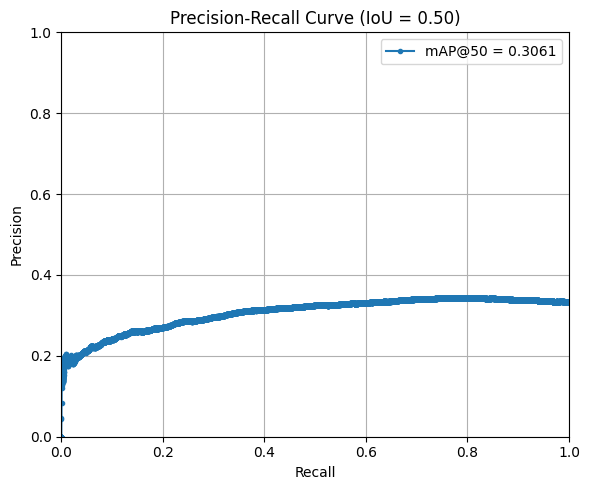

np.float64(0.3060747275711414)

In [4]:
from metrics.extract_metrics import compute_map50

map50 = compute_map50(df, plot=True)
map50

## Visualizing Results

#### Reproducing figures from the paper

#### Figure 5

Processing spatial_res: 0.44, amplitudal_res: 16
Processing spatial_res: 0.44, amplitudal_res: 24
Processing spatial_res: 0.44, amplitudal_res: 34
Processing spatial_res: 0.44, amplitudal_res: 38
Processing spatial_res: 0.44, amplitudal_res: 46
Processing spatial_res: 0.70, amplitudal_res: 16
Processing spatial_res: 0.70, amplitudal_res: 24
Processing spatial_res: 0.70, amplitudal_res: 34
Processing spatial_res: 0.70, amplitudal_res: 38
Processing spatial_res: 0.70, amplitudal_res: 46
Processing spatial_res: 1.00, amplitudal_res: 16
Processing spatial_res: 1.00, amplitudal_res: 24
Processing spatial_res: 1.00, amplitudal_res: 34
Processing spatial_res: 1.00, amplitudal_res: 38
Processing spatial_res: 1.00, amplitudal_res: 46


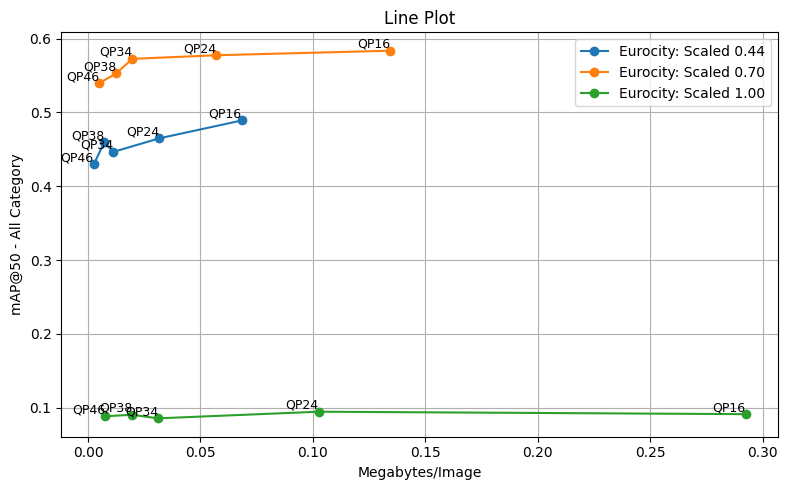

In [9]:
from visualization.xy_lineplot import basic_lineplot, multi_lineplot
from collections import defaultdict

# Step 1: Group by both 'spatial_res' and 'amplitudal_res'
grouped = df.groupby(['spatial_res', 'amplitudal_res'])

# Step 2: Compute mean megabytes and mAP@50 per group
plot_data = defaultdict(lambda: ([], [], []))  # spatial_res -> (x_list, y_list)

for (spatial_res, amplitudal_res), group in grouped:
    print(f"Processing spatial_res: {spatial_res}, amplitudal_res: {amplitudal_res}")
    map50 = compute_map50(group, plot=False)  # Compute mAP@50 for the group
    megabytes = group['image_size_mb'].mean()
    plot_data[f'Eurocity: Scaled {spatial_res}'][0].append(megabytes)
    plot_data[f'Eurocity: Scaled {spatial_res}'][1].append(map50)
    plot_data[f'Eurocity: Scaled {spatial_res}'][2].append(f'QP{amplitudal_res}')


# Step 3: Sort each line’s data by megabytes to ensure correct plotting
for spatial_res in plot_data:
    megabytes, map_scores, texts = plot_data[spatial_res]
    sorted_pairs = sorted(zip(megabytes, map_scores, texts))
    x_sorted, y_sorted, texts = zip(*sorted_pairs)
    plot_data[spatial_res] = (list(x_sorted), list(y_sorted), list(texts))

multi_lineplot(
    data_dict=plot_data,
    xlabel="Megabytes/Image",
    ylabel="mAP@50 - All Category"
)

Processing spatial_res: 0.44, amplitudal_res: 16
Processing spatial_res: 0.44, amplitudal_res: 24
Processing spatial_res: 0.44, amplitudal_res: 34
Processing spatial_res: 0.44, amplitudal_res: 38
Processing spatial_res: 0.44, amplitudal_res: 46
Processing spatial_res: 0.70, amplitudal_res: 16
Processing spatial_res: 0.70, amplitudal_res: 24
Processing spatial_res: 0.70, amplitudal_res: 34
Processing spatial_res: 0.70, amplitudal_res: 38
Processing spatial_res: 0.70, amplitudal_res: 46
Processing spatial_res: 1.00, amplitudal_res: 16
Processing spatial_res: 1.00, amplitudal_res: 24
Processing spatial_res: 1.00, amplitudal_res: 34
Processing spatial_res: 1.00, amplitudal_res: 38
Processing spatial_res: 1.00, amplitudal_res: 46


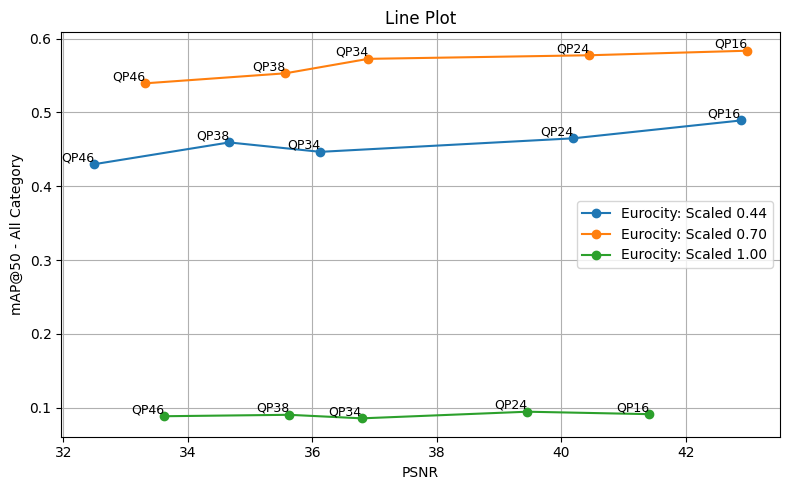

In [11]:
from visualization.xy_lineplot import basic_lineplot, multi_lineplot
from collections import defaultdict

# Step 1: Group by both 'spatial_res' and 'amplitudal_res'
grouped = df.groupby(['spatial_res', 'amplitudal_res'])

# Step 2: Compute mean megabytes and mAP@50 per group
plot_data = defaultdict(lambda: ([], [], []))  # spatial_res -> (x_list, y_list)

for (spatial_res, amplitudal_res), group in grouped:
    print(f"Processing spatial_res: {spatial_res}, amplitudal_res: {amplitudal_res}")
    map50 = compute_map50(group, plot=False)  # Compute mAP@50 for the group
    megabytes = group['psnr'].mean()
    plot_data[f'Eurocity: Scaled {spatial_res}'][0].append(megabytes)
    plot_data[f'Eurocity: Scaled {spatial_res}'][1].append(map50)
    plot_data[f'Eurocity: Scaled {spatial_res}'][2].append(f'QP{amplitudal_res}')


# Step 3: Sort each line’s data by megabytes to ensure correct plotting
for spatial_res in plot_data:
    megabytes, map_scores, texts = plot_data[spatial_res]
    sorted_pairs = sorted(zip(megabytes, map_scores, texts))
    x_sorted, y_sorted, texts = zip(*sorted_pairs)
    plot_data[spatial_res] = (list(x_sorted), list(y_sorted), list(texts))

multi_lineplot(
    data_dict=plot_data,
    xlabel="PSNR",
    ylabel="mAP@50 - All Category"
)

Processing spatial_res: 0.44, amplitudal_res: 16
Processing spatial_res: 0.44, amplitudal_res: 24
Processing spatial_res: 0.44, amplitudal_res: 34
Processing spatial_res: 0.44, amplitudal_res: 38
Processing spatial_res: 0.44, amplitudal_res: 46
Processing spatial_res: 0.70, amplitudal_res: 16
Processing spatial_res: 0.70, amplitudal_res: 24
Processing spatial_res: 0.70, amplitudal_res: 34
Processing spatial_res: 0.70, amplitudal_res: 38
Processing spatial_res: 0.70, amplitudal_res: 46
Processing spatial_res: 1.00, amplitudal_res: 16
Processing spatial_res: 1.00, amplitudal_res: 24
Processing spatial_res: 1.00, amplitudal_res: 34
Processing spatial_res: 1.00, amplitudal_res: 38
Processing spatial_res: 1.00, amplitudal_res: 46


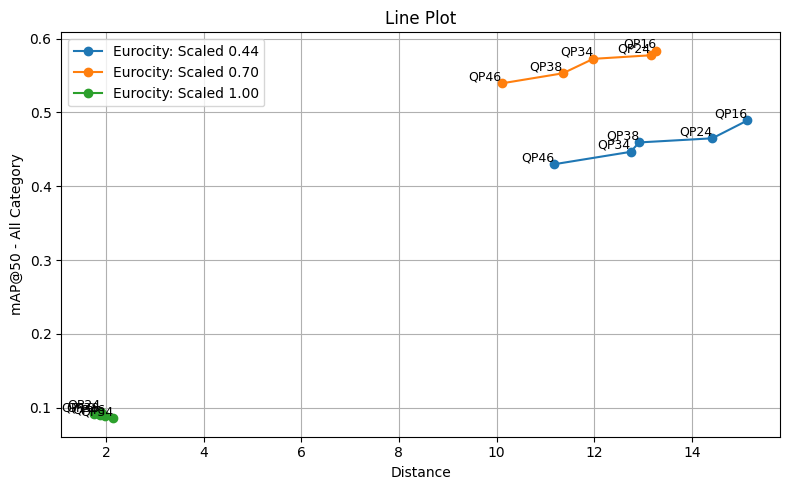

In [12]:
from visualization.xy_lineplot import basic_lineplot, multi_lineplot
from collections import defaultdict

# Step 1: Group by both 'spatial_res' and 'amplitudal_res'
grouped = df.groupby(['spatial_res', 'amplitudal_res'])

# Step 2: Compute mean megabytes and mAP@50 per group
plot_data = defaultdict(lambda: ([], [], []))  # spatial_res -> (x_list, y_list)

for (spatial_res, amplitudal_res), group in grouped:
    print(f"Processing spatial_res: {spatial_res}, amplitudal_res: {amplitudal_res}")
    map50 = compute_map50(group, plot=False)  # Compute mAP@50 for the group
    megabytes = group['distance'].mean()
    plot_data[f'Eurocity: Scaled {spatial_res}'][0].append(megabytes)
    plot_data[f'Eurocity: Scaled {spatial_res}'][1].append(map50)
    plot_data[f'Eurocity: Scaled {spatial_res}'][2].append(f'QP{amplitudal_res}')


# Step 3: Sort each line’s data by megabytes to ensure correct plotting
for spatial_res in plot_data:
    megabytes, map_scores, texts = plot_data[spatial_res]
    sorted_pairs = sorted(zip(megabytes, map_scores, texts))
    x_sorted, y_sorted, texts = zip(*sorted_pairs)
    plot_data[spatial_res] = (list(x_sorted), list(y_sorted), list(texts))

multi_lineplot(
    data_dict=plot_data,
    xlabel="Distance",
    ylabel="mAP@50 - All Category"
)

Distance category: (0, 10], mAP@50: 0.9642857142857143
Distance category: (0, 10], mAP@50: 0.9908256880733946
Distance category: (0, 10], mAP@50: 0.9714285714285714
Distance category: (10, 20], mAP@50: 0.9970149253731344
Distance category: (10, 20], mAP@50: 0.998062015503876
Distance category: (10, 20], mAP@50: 0.9859154929577465
Distance category: (20, 30], mAP@50: 0.996875
Distance category: (20, 30], mAP@50: 0.9981412639405205
Distance category: (20, 30], mAP@50: 0.9913793103448276
Distance category: (30, 40], mAP@50: 0.995850622406639
Distance category: (30, 40], mAP@50: 0.9971830985915493
Distance category: (30, 40], mAP@50: 0.988095238095238
Distance category: (40, 50], mAP@50: 0.9930555555555555
Distance category: (40, 50], mAP@50: 0.9957264957264956
Distance category: (40, 50], mAP@50: 0.9629629629629629
Distance category: (50, 60], mAP@50: 0.9803921568627452
Distance category: (50, 60], mAP@50: 0.9897959183673469
Distance category: (50, 60], mAP@50: 0.9629629629629629
Distance

C:\Users\Lauri Warsen\AppData\Local\Temp\ipykernel_4124\3400530789.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_distance = df.groupby(['distance_category', 'spatial_res'])


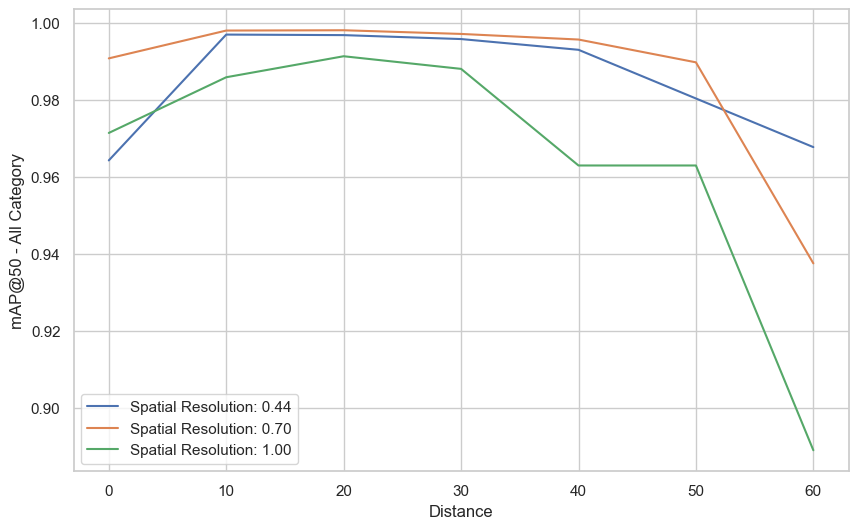

In [27]:
bins = list(range(0, 75, 10))
df['distance_category'] = pd.cut(df['distance'], bins=bins)
grouped_distance = df.groupby(['distance_category', 'spatial_res'])
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
spatial_res_distance_dict = {}
for (distance_label, spatial_resolution), group in grouped_distance:
    curr_map_50 = compute_map50(group, plot=False)
    print(f"Distance category: {distance_label}, mAP@50: {curr_map_50}")
    if spatial_resolution not in spatial_res_distance_dict:
        spatial_res_distance_dict[spatial_resolution] = []
    spatial_res_distance_dict[spatial_resolution].append(curr_map_50)

plt.figure(figsize=(10, 6))
plt.xlabel("Distance")
plt.ylabel("mAP@50 - All Category")

for spatial_res, spa in spatial_res_distance_dict.items():
    plt.plot(bins[:-1], spa, label=f"Spatial Resolution: {spatial_res}")
plt.legend()
plt.show()